# Uvod
**Student**: Branko Milošević IT 26-2020

**Predmet**: Principi prezentacije i prepoznavanja oblika

**Tema projektnog zadatka**: Detekcija godina, pola i emocija

Duboko učenje je oblast mašinskog učenja koja se zasniva na primeni neuronskih mreža sa više slojeva, poznatih i kao duboke neuronske mreže, koje omogućavaju automatsko učenje reprezentacija podataka.

Konvolucione neuronske mreže (CNN) posebno su optimizovane za obradu slika. One koriste konvolucione slojeve koji se primenjuju na ulazne slike radi izdvajanja različitih karakteristika — na primer, ivica, tekstura ili oblika. Konvolucioni filteri (ili „jezgra“) klize preko slike i izvode operaciju skalarnog proizvoda između vrednosti piksela i elemenata filtera, čime se dobija mapa karakteristika koja sadrži informacije o prisustvu određenih osobina u slici.

Nakon konvolucionih slojeva, slojevi za objedinjavanje (Pooling slojevi) se obično koriste za smanjenje dimenzionalnosti mapa karakteristika. Na taj način se smanjuje broj parametara u mreži i povećava otpornost modela na prostorne translacije (pomeranja slike).

Na kraju mreže, potpuno povezani slojevi (Fully Connected Layers, FC slojevi) se obično koriste za klasifikaciju na osnovu izdvojenih karakteristika. Svi neuroni u potpuno povezanom sloju povezani su sa svim neuronima iz prethodnog sloja, što omogućava modelu da nauči složene nelinearne odnose između različitih karakteristika slike.

U sledećoj ćeliji prikazan je kod koji sadrži celokupnu proceduru treniranja modela za detekciju pola osobe na slikama, korišćenjem transfer učenja zasnovanog na unapred obučenom VGG16 modelu.

Model VGG16, prethodno obučen na ImageNet skupu podataka, učitava se zajedno sa težinama koje su već naučene tokom ranijeg procesa treniranja.

Slojevi ovog unapred obučenog modela se „zamrzavaju“ podešavanjem parametra trainable = False, što znači da se njihovi parametri neće menjati tokom daljeg procesa optimizacije. Na ovaj način se iskorišćavaju već naučeni filteri iz originalnog modela, čime se ubrzava treniranje i sprečava gubitak prethodno stečenog znanja.

Na vrh postojećeg modela dodaju se novi slojevi, prilagođeni konkretnom zadatku — u ovom slučaju, klasifikaciji pola.

Slike se pripremaju pomoću objekta ImageDataGenerator, koji primenjuje različite transformacije nad slikama (kao što su reskaliranje, rotacija, zumiranje i horizontalno okretanje), čime se povećava raznovrsnost podataka i poboljšava sposobnost generalizacije modela.

Skup za treniranje se učitava iz direktorijuma „train“ korišćenjem metode flow_from_directory, dok se prethodno definisani generator koristi za automatsku obradu i dopremanje slika tokom procesa treniranja.

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Učitavanje VGG-Face modela, koji je baziran na ImageNet slikama
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Transfer learning --- Feature extraction, "zamrzavanjem" slojeva, unapređujemo model sa našim setom trening slika, i imamo benefite već istreniranog modela koji možemo primeniti na naš
# slučaj upotrebe.
for layer in base_model.layers:
    layer.trainable = False

# Na slojeve modela dodajemo naš sloj.
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Definišemo sloj za klasifikaciju pola (1 neuron)

# Kombinovanje modela sa našim novim slojem.
model = Model(inputs=base_model.input, outputs=predictions)

# Kompilacija modela pomoću Adam optimizatora (preporučen za rad sa slikama), baziran na SGD (stohastičnom gradijentnom padu)
# lr predstavlja stopu učenja odnosno koliko će model pomerati varijacije prilikom računanja funkcije gubitka (tako da gubitak bude minimiziran).
# i algoritmom gubitka binarne unakrsne entropije, koja je pogodna za probleme binarne klasifikacije (kao što je određivanje pola)
# Kao metrika evaluacije modela izabrana je tačnost umesto preciznosti, zato što su prosleđene slike balansirane, odnosno poseduju sličan broj slika osoba muškog i ženskog pola.
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Menjanje podataka
train_datagen = ImageDataGenerator(
    rescale=1./255, #Normalizovanje pixela slike na vrednosti između 0 i 1
    shear_range=0.2, #Svaka slika će se nagnuti za 0.2 radijana
    zoom_range=0.2, #Svaka slika će se uvećati ili smanjiti za 20%
    horizontal_flip=True #Postoji 50% šansa da će se slike horizontalno rotirati i imati efekat ogledala.
)


# Učitvanje slika koje se koriste za treniranje
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Faces_AgeGenderEmotionDetection/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Treniranje modela
model.fit(
    train_generator,
    epochs=5,  # Broj epoha
    steps_per_epoch=len(train_generator), #Broj koraka u jednoj epohi, odnosno iteracija uzimanja svih slika i pokretanja mreže
    verbose=1
)

# Model se čuva u fajlove na colab-u
model.save('gender_detection_model.h5')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 93 images belonging to 5 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 63s 19s/step - accuracy: 0.1773 - loss: -1.1291
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 80s 19s/step - accuracy: 0.1812 - loss: -3.5837
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 84s 20s/step - accuracy: 0.2008 - loss: -5.2593
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 61s 19s/step - accuracy: 0.1912 - loss: -8.3705
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 60s 20s/step - accuracy: 0.1871 - loss: -9.8649


Nakon kreiranog modela, potrebno je i testirati ga.

In [ ]:
!pip install deepface
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.3/128.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.5 MB/s eta 0:00:00


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step
Predicted Gender: Male


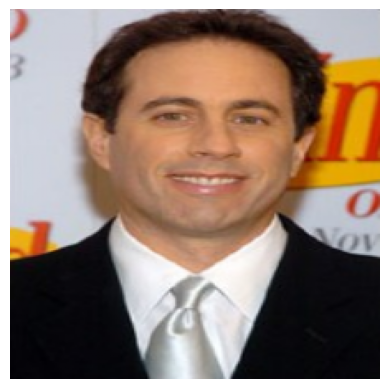

In [ ]:
#Testiranje kreiranog modela

import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import cv2 #Koristimo CV2 biblioteku da bi mogli da radimo sa slikama
import numpy as np #Numpy biblioteka se poziva radi lakšeg rada sa podacima

# Učitavanje modela
model = load_model('gender_detection_model.h5')

# Probaćemo samo 1 sliku, te je formatiramo sa istim parametrima kao i tokom treninga modela.
test_image_path = '/content/drive/MyDrive/Faces_AgeGenderEmotionDetection/train/jerry_seinfeld/httpgraphicsnytimescomimagessectionmoviesfilmographyWireImagejpg.jpg'
img = cv2.imread(test_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))

# Normalizacija pixel vrednosti na 0 do 1 (brži rad modela sa slikama)
img = img / 255.0

# Dodavanje dimenzija koje model očekuje (test slika poseduje 3 dimenzije, a model očekuje 4)
img = np.expand_dims(img, axis=0)

# Predikcija
predictions = model.predict(img)

predicted_class = 1 if predictions[0] > 0.5 else 0

print(f"Predicted Gender: {'Male' if predicted_class == 1 else 'Female'}")

# Da bi sliku prikazali moramo obrisati dodatu dimenziju
img = img[0]

plt.imshow(img)
plt.axis('off')
plt.show()

U narednoj ćeliji prikazan je postupak preuzimanja dataset-a sa Google Drive-a, zatim raspakivanja datoteka, nakon čega su kao rezultat prikazani direktorijumi koji se nalaze unutar ZIP arhive.

Korišćeni dataset sastoji se od slika koje su raspoređene u tri glavna direktorijuma: data, train i val. Direktorijumi train i val sadrže poddirektorijume sa slikama glumaca — Jerry Seinfeld, Ben Affleck, Elton John, Madonna i Mindy Kaling — dok direktorijum data obuhvata pomenuta dva direktorijuma sa istim sadržajem.

In [ ]:
file_id = '1GKkFFmYHY2Ay_umjBdqQ_7oM8D--raia'
download_link = f'https://drive.google.com/uc?id={file_id}'

!wget -O Faces_AgeGenderEmotionDetection.zip $download_link

--2025-10-18 14:29:57--  https://drive.google.com/uc?id=1GKkFFmYHY2Ay_umjBdqQ_7oM8D--raia
Resolving drive.google.com (drive.google.com)... 172.217.204.100, 172.217.204.101, 172.217.204.139, ...
Connecting to drive.google.com (drive.google.com)|172.217.204.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1GKkFFmYHY2Ay_umjBdqQ_7oM8D--raia [following]
--2025-10-18 14:29:58--  https://drive.usercontent.google.com/download?id=1GKkFFmYHY2Ay_umjBdqQ_7oM8D--raia
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.210.132, 2607:f8b0:400c:c0f::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.210.132|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://accounts.google.com/ServiceLogin?service=wise&passive=1209600&continue=https://drive.usercontent.google.com/download?id%3D1GKkFFmYHY2Ay_umjBdqQ_7oM8D--raia&followup

In [ ]:
import zipfile #Za ekstrakciju datoteke
import os #Za kreiranje foldera unutar colaba

zip_file_path = '/content/drive/MyDrive/Faces_AgeGenderEmotionDetection.zip'

extract_dir = '/content/Material/'

#Ukoliko folder ne postoji, kreirati ga
os.makedirs(extract_dir, exist_ok=True)

# Ekstrakcija dataset-a
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Lista fajlova (foldera unutar dataseta)
extracted_files = os.listdir(extract_dir)
print("Extracted files:", extracted_files)

Extracted files: ['train', 'val', 'data']


# Prikaz sadržaja direktorijuma.
Za svaku sliku najpre se formira putanja do datoteke pomoću funkcije os.path.join, čime se dobija apsolutna putanja do svake slike. Nakon toga, funkcija plt.imread se koristi za učitavanje slike, dok se metod imshow primenjuje za prikaz slike na odgovarajućoj poziciji unutar grafikona.
Pozivom axis('off') isključuje se prikaz oznake osa (x i y) radi jasnijeg i preglednijeg prikaza slike.

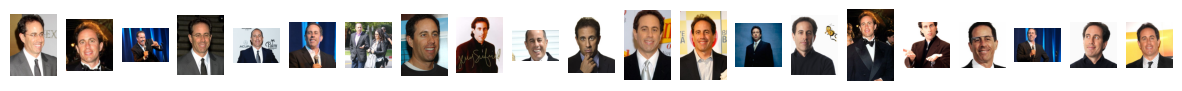

In [ ]:
import matplotlib.pyplot as plt #Matplot za prikazivanje slika
import os

# Putanja do foldera sa slikama radi prikaza
folder_path = '/content/Material/train/jerry_seinfeld'

# Svaki fajl unutar foldera (list dir) se proverava, i ukoliko je stvarno fajl (a ne folder), dodaje se na putanju foldera i kao rezultat dobijamo niz imena fajlova za dalji prikaz
#npr. *putanja*/slika1.jpg, *putanja*/slika2.jpg
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Postavljanje veličine grafa
fig, axes = plt.subplots(1, len(image_files), figsize=(15, 5))  # 1 red, broj kolona koliko imamo slika, veličina 15x5 inch-a

# Za svaku sliku...
for i, image_file in enumerate(image_files):
    image_path = os.path.join(folder_path, image_file)

    # Učitaj sliku na osnovu putanje foldera + putanje slike
    image = plt.imread(image_path)

    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

# **DeepFace**
Model DeepFace odnosi se na specifičan sistem za prepoznavanje ljudskih lica, koji je stekao veliku popularnost u oblasti detekcije i identifikacije lica na fotografijama. Najpoznatiju verziju ovog modela razvio je Facebook AI Research (FAIR) tim 2014. godine.

Ovaj model zasniva se na upotrebi dubokih neuronskih mreža, tačnije konvolucionih neuronskih mreža (CNN), koje omogućavaju preciznu detekciju i prepoznavanje lica u slikama.
Originalna verzija DeepFace modela sastoji se od više konvolucionih i potpuno povezanih slojeva, obučenih na velikom broju primera lica, što omogućava postizanje izuzetno visokog nivoa tačnosti u prepoznavanju.

25-10-18 14:42:44 - Directory /root/.deepface has been created
25-10-18 14:42:44 - Directory /root/.deepface/weights has been created


Action: gender:   0%|          | 0/3 [00:00<?, ?it/s] Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5
To: /root/.deepface/weights/gender_model_weights.h5


25-10-18 14:42:48 - 🔗 gender_model_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5 to /root/.deepface/weights/gender_model_weights.h5...



  0%|          | 0.00/537M [00:00<?, ?B/s]
  2%|▏         | 11.0M/537M [00:00<00:04, 106MB/s]
  5%|▍         | 26.7M/537M [00:00<00:03, 135MB/s]
 10%|█         | 54.0M/537M [00:00<00:02, 195MB/s]
 14%|█▍        | 77.6M/537M [00:00<00:02, 211MB/s]
 20%|█▉        | 105M/537M [00:00<00:01, 234MB/s] 
 24%|██▍       | 129M/537M [00:00<00:01, 220MB/s]
 28%|██▊       | 152M/537M [00:00<00:01, 212MB/s]
 32%|███▏      | 174M/537M [00:00<00:01, 214MB/s]
 37%|███▋      | 199M/537M [00:00<00:01, 224MB/s]
 41%|████      | 221M/537M [00:01<00:01, 192MB/s]
 45%|████▌     | 244M/537M [00:01<00:01, 200MB/s]
 49%|████▉     | 265M/537M [00:01<00:01, 187MB/s]
 53%|█████▎    | 286M/537M [00:01<00:01, 194MB/s]
 57%|█████▋    | 307M/537M [00:01<00:01, 197MB/s]
 63%|██████▎   | 336M/537M [00:01<00:00, 222MB/s]
 67%|██████▋   | 360M/537M [00:01<00:00, 227MB/s]
 72%|███████▏  | 386M/537M [00:01<00:00, 236MB/s]
 76%|███████▋  | 410M/537M [00:01<00:00, 232MB/s]
 81%|████████  | 434M/537M [00:02<00:00, 227MB/s]
 

25-10-18 14:42:55 - 🔗 age_model_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5 to /root/.deepface/weights/age_model_weights.h5...



  0%|          | 0.00/539M [00:00<?, ?B/s]
  0%|          | 524k/539M [00:00<04:12, 2.13MB/s]
  4%|▍         | 21.5M/539M [00:00<00:06, 75.5MB/s]
  7%|▋         | 36.7M/539M [00:00<00:04, 101MB/s] 
 10%|█         | 55.6M/539M [00:00<00:03, 129MB/s]
 13%|█▎        | 71.3M/539M [00:00<00:03, 138MB/s]
 17%|█▋        | 91.2M/539M [00:00<00:02, 157MB/s]
 20%|██        | 109M/539M [00:00<00:02, 151MB/s] 
 23%|██▎       | 125M/539M [00:01<00:03, 133MB/s]
 26%|██▋       | 142M/539M [00:01<00:02, 142MB/s]
 29%|██▉       | 157M/539M [00:01<00:02, 138MB/s]
 33%|███▎      | 176M/539M [00:01<00:02, 152MB/s]
 36%|███▌      | 193M/539M [00:01<00:02, 157MB/s]
 39%|███▉      | 210M/539M [00:01<00:02, 161MB/s]
 43%|████▎     | 230M/539M [00:01<00:01, 170MB/s]
 46%|████▌     | 247M/539M [00:01<00:01, 156MB/s]
 49%|████▉     | 263M/539M [00:04<00:13, 20.9MB/s]
 52%|█████▏    | 282M/539M [00:04<00:08, 29.0MB/s]
 55%|█████▍    | 295M/539M [00:04<00:06, 35.9MB/s]
 57%|█████▋    | 309M/539M [00:04<00:05, 43.

25-10-18 14:43:09 - 🔗 facial_expression_model_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5 to /root/.deepface/weights/facial_expression_model_weights.h5...



100%|██████████| 5.98M/5.98M [00:00<00:00, 78.8MB/s]
Action: emotion: 100%|██████████| 3/3 [00:24<00:00,  8.20s/it]


[{'gender': {'Woman': np.float32(0.010813883), 'Man': np.float32(99.98919)}, 'dominant_gender': 'Man', 'region': {'x': 6, 'y': 29, 'w': 82, 'h': 82, 'left_eye': None, 'right_eye': None}, 'face_confidence': 0.9, 'age': 26, 'emotion': {'angry': np.float32(0.043426607), 'disgust': np.float32(1.6059012e-05), 'fear': np.float32(0.019489247), 'happy': np.float32(7.7451677), 'sad': np.float32(9.831557), 'surprise': np.float32(0.0008879242), 'neutral': np.float32(82.35946)}, 'dominant_emotion': 'neutral'}]


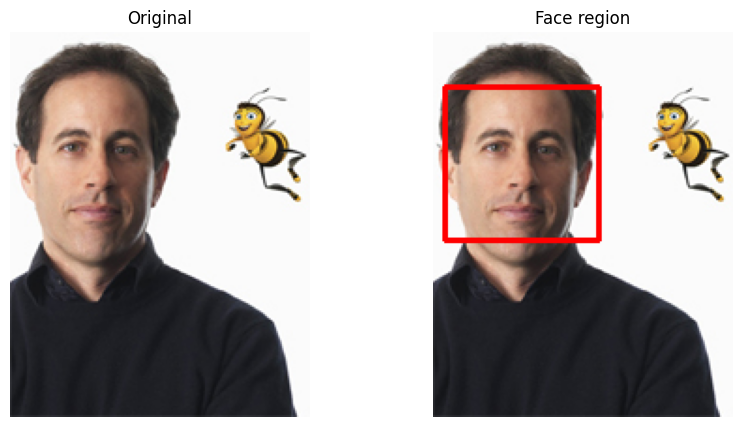

In [ ]:
import cv2 #Za rad sa slikama i prosleđivanje modelu
from deepface import DeepFace

# Originalna slika
original_img = cv2.imread('/content/Material/train/jerry_seinfeld/httpimagesrottentomatoescomimagesspotlightsnewsjerryseinfeldjpg.jpg')

# Kopija slike za prikaz regije koju deepface detektuje kao lice
img_with_region = original_img.copy()

results = DeepFace.analyze(img_with_region, actions=["gender", "age", "emotion"]) #Deepface.analyze funkcija može odrediti
              # pol, starost, emociju i rasu osobe na slici, za potrebe zadatka potrebno je samo prva 3 atributa
print(results)
# Na osnovu rezultata funkcije, definišemo region pravougaonika
region = results[0]['region']
x, y, w, h = region['x'], region['y'], region['w'], region['h']

# Nacrtaj pravougaonik
cv2.rectangle(img_with_region, (x, y), (x + w, y + h), (0, 0, 255), 2)  # BGR

# 1 red, 2 kolone
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Prikaz originalne slike
axes[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)) #CV2 Biblioteka radi sa slikama u BGR spektru, dok je originalna slika u RGB spektru
axes[0].axis('off')
axes[0].set_title('Original')

axes[1].imshow(cv2.cvtColor(img_with_region, cv2.COLOR_BGR2RGB))
axes[1].axis('off')
axes[1].set_title('Face region')

plt.show()

Action: gender: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


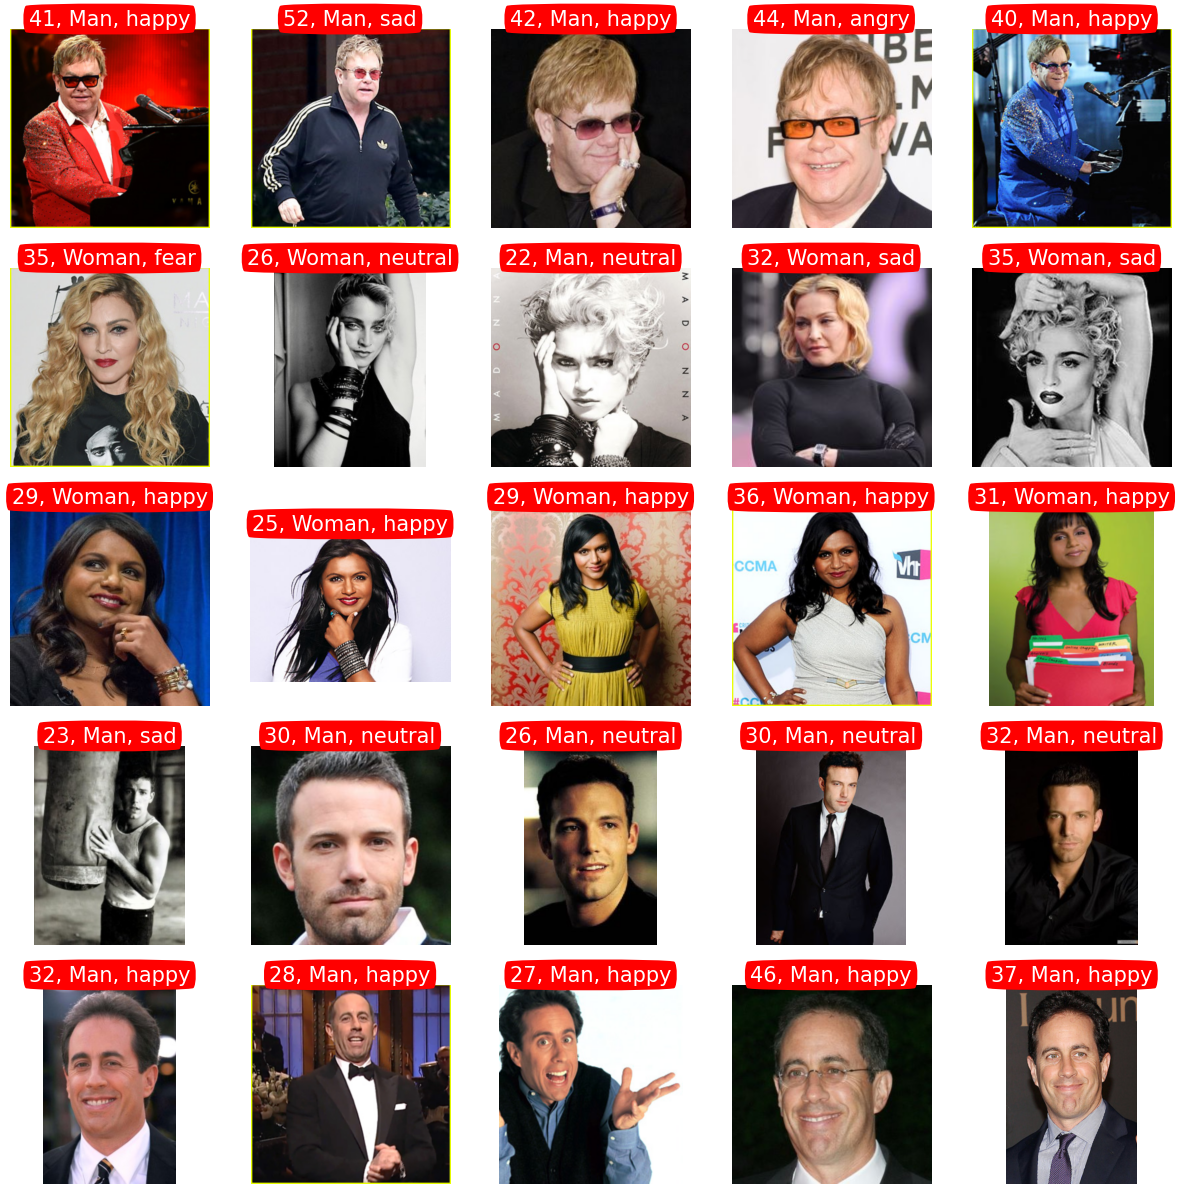

In [ ]:
from deepface import DeepFace
import cv2
import matplotlib.pyplot as plt
from glob import glob

# Lista svih slika unutar validation foldera
image_files = glob('/content/Material/val/**/*.jpg', recursive=True)

num_columns = 5 #5 redova za 25 slika
num_rows = 5 #5 kolona

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15)) #15x15 inch-a

j = 0

#Za svaku putanju slike..
for img_file in image_files:
    img = cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB) #Učitaj sliku u originalnoj boji radi prikaza na grafu

    img_h, img_w, _ = img.shape #Sa obzirom da je sada slika učitana kao numpy niz, prva vrednost je visina, druga je širina, treća je spektar boje (- ignoriše spektar boje, zato što je već podešen)
    r = 640 / max(img_h, img_w) #Standardizacija veličine slike (u ovom koraku se pamti razmera rezolucije,
    # slika se standardizuje tako da pre prosleđivanja modelu slike budu iste veličine)
    img = cv2.resize(img, (int(img_w * r), int(img_h * r)))

    results = DeepFace.analyze(img_file, actions=['age', 'emotion', 'gender'], enforce_detection=False) #Ukoliko deepface ne može detektovati lice, izvršavanje se nastavlja.

    #Prvi rezultat u nizu predstavlja rezultat predikcije za trenutnu sliku u iteraciji, pristupamo vrednostima koje smo dobili
    predicted_gender = results[0]['dominant_gender']
    predicted_age = results[0]['age']
    predicted_emotion = results[0]['dominant_emotion']

    # Kreiranje labele radi prikaza rezultata
    label = "{}, {}, {}".format(int(predicted_age), predicted_gender, predicted_emotion)

    text_x = j // num_columns
    text_y = j % num_columns

    #Tekst i pozadinska boja
    axes[text_x, text_y].text(
        0.5, 1.05, label, fontsize=15, color='white',
        bbox=dict(facecolor='red', alpha=1, edgecolor='none', boxstyle='round4'),
        transform=axes[text_x, text_y].transAxes, ha='center', va='center'
    )
    axes[text_x, text_y].imshow(img)
    axes[text_x, text_y].axis('off')
    j += 1

plt.show()

# **Zaključak**

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = load_model('gender_detection_model.h5')

test_datagen = ImageDataGenerator(rescale=1./255) #Normalizacija slika

test_generator = test_datagen.flow_from_directory(
    '/content/Material/val',
    target_size=(224, 224),
    batch_size=3,
    class_mode='binary',
    shuffle=False
)

eval_result = model.evaluate(test_generator)

accuracy = eval_result[1]

print(f'Accuracy: {accuracy * 100:.2f}%')

Found 25 images belonging to 5 classes.
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.2485 - loss: -1.3458
Accuracy: 20.00%


In [ ]:
from deepface import DeepFace
import os
from glob import glob


test_dir = '/content/Material/val'

correct_predictions = 0
total_images = 0

for image_file in glob('/content/Material/val/**/*.jpg', recursive=True):
    image_path = os.path.join(test_dir, image_file)

    results = DeepFace.analyze(image_path, actions=['gender'], enforce_detection=False)

    predicted_gender = results[0]['dominant_gender']

    actual_gender = 'Man' if 'male' == os.path.basename(os.path.dirname(image_path)).lower() else 'Woman'

    correct_prediction = predicted_gender.lower() == actual_gender.lower()
    if correct_prediction:
        correct_predictions += 1

    total_images += 1

accuracy = (correct_predictions / total_images) * 100
print(correct_predictions)
print(total_images)
print(f"Accuracy: {accuracy:.2f}%")

9
25
Accuracy: 36.00%


Na osnovu dobijenih rezultata može se uočiti da **DeepFace** model ostvaruje viši nivo tačnosti u poređenju sa modelom kreiranim u okviru praktičnog dela projekta. Ovakav ishod je očekivan, s obzirom na to da DeepFace koristi dublju arhitekturu i unapred trenirane težine na velikim skupovima podataka, što mu omogućava bolje generalizovanje i precizniju klasifikaciju.

Takođe, primećeno je da kvalitet i karakteristike ulaznih slika (poput osvetljenja, ugla lica, rezolucije i izraza) imaju značajan uticaj na performanse oba modela. Varijacije u tim faktorima mogu otežati detekciju lica i precizno prepoznavanje starosti ili emocija, što ukazuje na potrebu za dodatnom optimizacijom i korišćenjem raznovrsnijeg skupa podataka u budućem radu.